# Importing Libraries :

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import statistics
from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Reading data :

In [2]:
%%time
root = Path('../input/ashrae-feather-format-for-fast-loading')

df_train = pd.read_feather(root/'train.feather')
df_weather_train = pd.read_feather(root/'weather_train.feather')
df_building = pd.read_feather(root/'building_metadata.feather')

CPU times: user 105 ms, sys: 744 ms, total: 848 ms
Wall time: 722 ms


In [3]:
# Copy from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]):
            # skip datetime type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Missing Value Imputation :

## Building meta data :

In [4]:
df_building = df_building.drop(["year_built","floor_count"],axis=1)

In [5]:
df_building['square_feet'] = np.log1p(df_building['square_feet'])

### Encoding primary_use 

In [6]:
primary_use_list = df_building['primary_use'].unique()#getting unique valuesof primary use
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
df_building['primary_use'] = df_building['primary_use'].map(primary_use_dict)#encoding with number 

del primary_use_list,primary_use_dict

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


In [7]:

#df_building.to_feather('new_building_metadata.feather')#storing the file

## Weather train data :

In [8]:
# retrieve cloud coverage data without NaN
def filling_missing_data(df) :
    
    df["day"] = pd.to_datetime(df["timestamp"]).dt.day 
    df["week"] = pd.to_datetime(df["timestamp"]).dt.week
    df["month"] = pd.to_datetime(df["timestamp"]).dt.month
    
    # Reset Index for Fast Update
    df = df.set_index(['site_id','day','month'])   
    
    cloud_coverage = df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    cloud_coverage = pd.DataFrame(cloud_coverage.fillna(method='ffill'),columns=["cloud_coverage"]) # imputing with daily means per site id
    df.update(cloud_coverage,overwrite=False)
  
    precip_depth = df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    precip_depth = pd.DataFrame(precip_depth.fillna(method='ffill'),columns=['precip_depth_1_hr'])
    df.update(precip_depth,overwrite=False)
    
    sea_level = df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    sea_level = pd.DataFrame(sea_level.fillna(method='ffill'),columns=['sea_level_pressure'])
    df.update(sea_level,overwrite=False)
    

    wind_direction =  pd.DataFrame(df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    df.update(wind_direction,overwrite=False)

    wind_speed =  pd.DataFrame(df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    df.update(wind_speed,overwrite=False)

    air_temperature = pd.DataFrame(df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    df.update(air_temperature,overwrite=False)
    
    due_temperature = pd.DataFrame(df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    df.update(due_temperature,overwrite=False)  

    df = df.reset_index()
    df = df.drop(['day','week','month'],axis=1)
    

In [9]:
filling_missing_data(df_weather_train)#calling function to fill missing values

In [10]:
df_weather_train = df_weather_train.drop(['day','week','month'],axis=1) 

# Adding features to weather data :

In [11]:
#https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115256
import holidays

en_holidays = holidays.England()#holidays list of  England
ir_holidays = holidays.Ireland()# holidays list of Ireland
ca_holidays = holidays.Canada()#holidays list of Canada
us_holidays = holidays.UnitedStates()# holidays list of US

en_idx = df_weather_train.query('site_id == 1 or site_id == 5').index
ir_idx = df_weather_train.query('site_id == 12').index
ca_idx = df_weather_train.query('site_id == 7 or site_id == 11').index
us_idx = df_weather_train.query('site_id == 0 or site_id == 2 or site_id == 3 or site_id == 4 or site_id == 6 or site_id == 8 or site_id == 9 or site_id == 10 or site_id == 13 or site_id == 14 or site_id == 15').index

df_weather_train['IsHoliday'] = 0
df_weather_train.loc[en_idx, 'IsHoliday'] = df_weather_train.loc[en_idx, 'timestamp'].apply(lambda x: en_holidays.get(x, default=0))
df_weather_train.loc[ir_idx, 'IsHoliday'] = df_weather_train.loc[ir_idx, 'timestamp'].apply(lambda x: ir_holidays.get(x, default=0))
df_weather_train.loc[ca_idx, 'IsHoliday'] = df_weather_train.loc[ca_idx, 'timestamp'].apply(lambda x: ca_holidays.get(x, default=0))
df_weather_train.loc[us_idx, 'IsHoliday'] = df_weather_train.loc[us_idx, 'timestamp'].apply(lambda x: us_holidays.get(x, default=0))

holiday_idx = df_weather_train['IsHoliday'] != 0
df_weather_train.loc[holiday_idx, 'IsHoliday'] = 1
df_weather_train['IsHoliday'] = df_weather_train['IsHoliday'].astype(np.uint8)

In [12]:
del en_idx,ir_idx,ca_idx,us_idx,holiday_idx

In [13]:
def add_lag_feature(df_weather, window=3):
    group_df = df_weather.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float32)#getting mean in given window size
    #lag_max = rolled.max().reset_index().astype(np.float32)# getting max in given window size 
    #lag_min = rolled.min().reset_index().astype(np.float32)# getting min in given window size
    #lag_std = rolled.std().reset_index().astype(np.float32) #getting std in given window size
    for col in cols:
        df_weather[f'{col}_mean_lag{window}'] = lag_mean[col]
        #df_weather[f'{col}_max_lag{window}'] = lag_max[col]
        #df_weather[f'{col}_min_lag{window}'] = lag_min[col]
        #df_weather[f'{col}_std_lag{window}'] = lag_std[col]
    del group_df,cols,rolled,lag_mean    #,lag_max,lag_min,lag_std


## Offsetting timestamp :

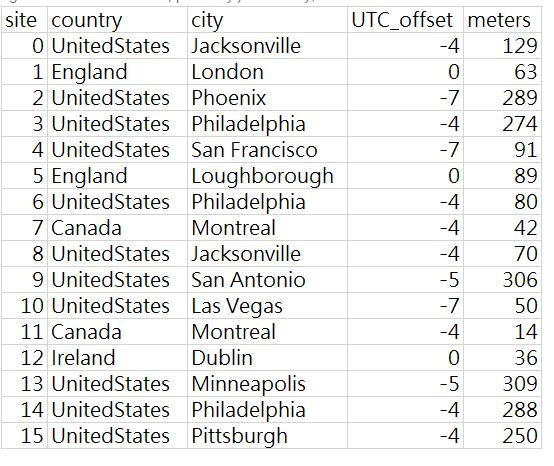

In [14]:
# offset in time zone in weather data
#train data is given UTC timezone whereas weather train data given local timezone
from IPython.display import Image
Image('../input/image-location/one.JPG') 

In [15]:
d1 = { 'offset' : [5,0,9,6,8,0,6,6,5,7,8,6,0,7,6,6]}# offsettig time
ind = [i for i in range(16)]
df1 = pd.DataFrame(d1,index = ind)
df1.index.name = 'site_id'
df2 = df1['offset']

In [16]:
def timestamp_align(df):
    df['offset'] = df.site_id.map(df2)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))#delaying according to timezone
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

In [17]:
df_weather_train = timestamp_align(df_weather_train)

In [18]:
df_weather_train = df_weather_train.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
df_weather_train = df_weather_train.drop(['offset'],axis = 1)

In [19]:
#df_weather_train.to_feather('new_weather_train.feather')

In [20]:
#add_lag_feature(df_weather_train, window=6)
#add_lag_feature(df_weather_train, window=72)
gc.collect()


40

In [21]:
df_weather_train = df_weather_train.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [22]:
#df_weather_train.to_feather('add_weather_train.feather') #storing the file

# Removing Outliers of train data :

In [23]:
df_train = df_train[df_train["building_id"] != 1099]#getting index of building id  1099
print("number of unique bulilding id's :",df_train['building_id'].nunique())

df_train = df_train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

number of unique bulilding id's : 1448


In [24]:
def preprocess(df):
    #df["hour"] = df["timestamp"].dt.hour #converting timestamp to hour
    df["weekend"] = df["timestamp"].dt.weekday
    #df["month"] = df["timestamp"].dt.month
    #df["dayofweek"] = df["timestamp"].dt.dayofweek
   

In [25]:
df_train['meter_reading_log1p'] = np.log1p(df_train['meter_reading'])   #convert meter reading to log value for rmse
preprocess(df_train)

In [26]:
df_group = df_train.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float32)
df_train['building_mean'] = df_train['building_id'].map(building_mean)
del df_group

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19852320 entries, 103 to 20216099
Data columns (total 7 columns):
 #   Column               Dtype         
---  ------               -----         
 0   building_id          int16         
 1   meter                int8          
 2   timestamp            datetime64[ns]
 3   meter_reading        float32       
 4   meter_reading_log1p  float32       
 5   weekend              int64         
 6   building_mean        float32       
dtypes: datetime64[ns](1), float32(3), int16(1), int64(1), int8(1)
memory usage: 738.4 MB


In [28]:
df_weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int8          
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139773 non-null  float32       
 3   cloud_coverage      122545 non-null  float32       
 4   dew_temperature     139773 non-null  float32       
 5   precip_depth_1_hr   113500 non-null  float32       
 6   sea_level_pressure  131018 non-null  float32       
 7   wind_direction      139773 non-null  float32       
 8   wind_speed          139773 non-null  float32       
 9   IsHoliday           139773 non-null  uint8         
dtypes: datetime64[ns](1), float32(7), int8(1), uint8(1)
memory usage: 5.1 MB


In [29]:
df_train = df_train.reset_index()
reduce_mem_usage(df_train)

Memory usage of dataframe is 738.37 MB
Memory usage after optimization is: 530.11 MB
Decreased by 28.2%


,index,building_id,meter,timestamp,meter_reading,meter_reading_log1p,weekend,building_mean
0,103,105,0,2016-01-01 00:00:00,23.303600,3.190624,4,4.317676
1,104,106,0,2016-01-01 00:00:00,0.374600,0.318163,4,0.887571
2,105,106,3,2016-01-01 00:00:00,0.000000,0.000000,4,0.887571
3,106,107,0,2016-01-01 00:00:00,175.184006,5.171529,4,4.572077
4,107,108,0,2016-01-01 00:00:00,91.265297,4.524668,4,5.458557
...,...,...,...,...,...,...,...,...
19852315,20216095,1444,0,2016-12-31 23:00:00,8.750000,2.277267,5,2.027276
19852316,20216096,1445,0,2016-12-31 23:00:00,4.825000,1.762159,5,1.719585
19852317,20216097,1446,0,2016-12-31 23:00:00,0.000000,0.000000,5,0.961074
19852318,20216098,1447,0,2016-12-31 23:00:00,159.574997,5.078761,5,5.228821


In [30]:
#df_train.to_feather('new_train.feather') #storing the file

In [31]:
#del df_train

# Test data :

In [32]:
df_weather_test = pd.read_feather('../input/ashrae-feather-format-for-fast-loading/weather_test.feather')

## Weather test data :

In [33]:
filling_missing_data(df_weather_test)#calling function to fill missing values

In [34]:
df_weather_test = df_weather_test.drop(['day','week','month'],axis=1) 

# Adding IsHoliday feature :

In [35]:
en_idx = df_weather_test.query('site_id == 1 or site_id == 5').index
ir_idx = df_weather_test.query('site_id == 12').index
ca_idx = df_weather_test.query('site_id == 7 or site_id == 11').index
us_idx = df_weather_test.query('site_id == 0 or site_id == 2 or site_id == 3 or site_id == 4 or site_id == 6 or site_id == 8 or site_id == 9 or site_id == 10 or site_id == 13 or site_id == 14 or site_id == 15').index

df_weather_test['IsHoliday'] = 0
df_weather_test.loc[en_idx, 'IsHoliday'] = df_weather_test.loc[en_idx, 'timestamp'].apply(lambda x: en_holidays.get(x, default=0))
df_weather_test.loc[ir_idx, 'IsHoliday'] = df_weather_test.loc[ir_idx, 'timestamp'].apply(lambda x: ir_holidays.get(x, default=0))
df_weather_test.loc[ca_idx, 'IsHoliday'] = df_weather_test.loc[ca_idx, 'timestamp'].apply(lambda x: ca_holidays.get(x, default=0))
df_weather_test.loc[us_idx, 'IsHoliday'] = df_weather_test.loc[us_idx, 'timestamp'].apply(lambda x: us_holidays.get(x, default=0))

holiday_idx = df_weather_test['IsHoliday'] != 0
df_weather_test.loc[holiday_idx, 'IsHoliday'] = 1
df_weather_test['IsHoliday'] = df_weather_test['IsHoliday'].astype(np.uint8)

In [36]:
del en_idx,ir_idx,ca_idx,us_idx,holiday_idx

In [37]:
df_weather_test = timestamp_align(df_weather_test)

In [38]:
df_weather_test = df_weather_test.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
df_weather_test = df_weather_test.drop(['offset'],axis = 1)

In [39]:
#df_weather_test.to_feather('new_weather_test.feather')

In [40]:
df_weather_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             277243 non-null  int8          
 1   timestamp           277243 non-null  datetime64[ns]
 2   air_temperature     277243 non-null  float32       
 3   cloud_coverage      244097 non-null  float32       
 4   dew_temperature     277243 non-null  float32       
 5   precip_depth_1_hr   225436 non-null  float32       
 6   sea_level_pressure  260002 non-null  float32       
 7   wind_direction      277243 non-null  float32       
 8   wind_speed          277243 non-null  float32       
 9   IsHoliday           277243 non-null  uint8         
dtypes: datetime64[ns](1), float32(7), int8(1), uint8(1)
memory usage: 10.0 MB


In [41]:
#add_lag_feature(df_weather_test, window=6)
#add_lag_feature(df_weather_test, window=72)
gc.collect()


60

In [42]:
df_weather_test = df_weather_test.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [43]:
#df_weather_test.to_feather('add_weather_test.feather')

In [44]:
df_weather_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             277243 non-null  int8          
 1   timestamp           277243 non-null  datetime64[ns]
 2   air_temperature     277243 non-null  float32       
 3   cloud_coverage      244097 non-null  float32       
 4   dew_temperature     277243 non-null  float32       
 5   precip_depth_1_hr   225436 non-null  float32       
 6   sea_level_pressure  260002 non-null  float32       
 7   wind_direction      277243 non-null  float32       
 8   wind_speed          277243 non-null  float32       
 9   IsHoliday           277243 non-null  uint8         
dtypes: datetime64[ns](1), float32(7), int8(1), uint8(1)
memory usage: 10.0 MB


## test data :

In [45]:
df_test = pd.read_feather('../input/ashrae-feather-format-for-fast-loading/test.feather')

In [46]:
preprocess(df_test)
df_test['building_mean'] = df_test['building_id'].map(building_mean)

In [47]:

reduce_mem_usage(df_test)
#df_test.to_feather('new_test.feather')

Memory usage of dataframe is 1073.68 MB
Memory usage after optimization is: 795.32 MB
Decreased by 25.9%


,row_id,building_id,meter,timestamp,weekend,building_mean
0,0,0,0,2017-01-01 00:00:00,6,5.432439
1,1,1,0,2017-01-01 00:00:00,6,4.761836
2,2,2,0,2017-01-01 00:00:00,6,2.998495
3,3,3,0,2017-01-01 00:00:00,6,5.873241
4,4,4,0,2017-01-01 00:00:00,6,7.342151
...,...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,2,2.027276
41697596,41697596,1445,0,2018-05-09 07:00:00,2,1.719585
41697597,41697597,1446,0,2018-05-09 07:00:00,2,0.961074
41697598,41697598,1447,0,2018-05-09 07:00:00,2,5.228821


In [48]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   row_id         int32         
 1   building_id    int16         
 2   meter          int8          
 3   timestamp      datetime64[ns]
 4   weekend        int8          
 5   building_mean  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int32(1), int8(2)
memory usage: 795.3 MB


# Merging :

In [49]:

target_train_df = df_train.merge(df_building, left_on='building_id',right_on='building_id',how='left')
target_train_df = target_train_df.merge(df_weather_train,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])

   


target_train_df["hour"] = target_train_df["timestamp"].dt.hour 
target_train_df["weekend"] = target_train_df["timestamp"].dt.weekday
target_train_df["day"] = pd.to_datetime(target_train_df["timestamp"]).dt.dayofyear
    
target_train_df['month_group'] = target_train_df['timestamp'].dt.month
target_train_df['month_group'].replace((1, 2, 3, 4), 1, inplace = True)
target_train_df['month_group'].replace((5, 6, 7, 8), 2, inplace = True)
target_train_df['month_group'].replace((9, 10, 11, 12), 3, inplace = True)
    
target_train_df = target_train_df.drop(['meter_reading','index'],axis = 1) 
target_train_df["primary_use"] = target_train_df["primary_use"].astype(np.int8)



In [50]:
#https://www.kaggle.com/c/ashrae-energy-prediction/discussion/124984

    #horizsolar is supposed to calculate the solar horizontal radiation coming into the building.
latitude_dict = {0 :28.5383,1 :50.9097,2 :33.4255,3 :38.9072,4 :37.8715,5 :50.9097,6 :40.7128,7 :45.4215,8 :28.5383,9 :30.2672,10 :40.10677,11 :45.4215,12 :53.3498,13 :44.9375,14 :38.0293,15: 40.7128,}

target_train_df['latitude'] = target_train_df['site_id'].map(latitude_dict)
target_train_df['solarHour'] = (target_train_df['hour']-12)*15 # to be removed
target_train_df['solarDec'] = -23.45*np.cos(np.deg2rad(360*(target_train_df['day']+10)/365)) # to be removed
target_train_df['horizsolar'] = np.cos(np.deg2rad(target_train_df['solarHour']))*np.cos(np.deg2rad(target_train_df['solarDec']))*np.cos(np.deg2rad(target_train_df['latitude'])) + np.sin(np.deg2rad(target_train_df['solarDec']))*np.sin(np.deg2rad(target_train_df['latitude']))
target_train_df['horizsolar'] = target_train_df['horizsolar'].apply(lambda x: 0 if x <0 else x)

target_train_df = target_train_df.drop(['latitude','solarHour','solarDec'], axis=1)
    # The sensible heat is a form of energy emitted into the atmosphere or absorbed
target_train_df['Sensible_Heat'] = 0.5274*(10.**(-4.))*target_train_df['square_feet']*(75.-target_train_df['air_temperature'])

target_train_df['relative_humidity'] = 100 * (np.exp((17.625 * target_train_df['dew_temperature']) / (243.04 + target_train_df['dew_temperature'])) / np.exp((17.625 * target_train_df['air_temperature'])/(243.04 + target_train_df['air_temperature'])))
   
#target_train_df = target_train_df.dropna()

       


In [51]:
target_train_df = reduce_mem_usage(target_train_df, use_float16=False)    
target_train_df = target_train_df.drop(['day','hour'],axis=1) 


Memory usage of dataframe is 2366.58 MB
Memory usage after optimization is: 1552.48 MB
Decreased by 34.4%


In [52]:
target_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19852320 entries, 0 to 19852319
Data columns (total 21 columns):
 #   Column               Dtype         
---  ------               -----         
 0   building_id          int16         
 1   meter                int8          
 2   timestamp            datetime64[ns]
 3   meter_reading_log1p  float32       
 4   weekend              int8          
 5   building_mean        float32       
 6   site_id              int8          
 7   primary_use          int8          
 8   square_feet          float32       
 9   air_temperature      float32       
 10  cloud_coverage       float32       
 11  dew_temperature      float32       
 12  precip_depth_1_hr    float32       
 13  sea_level_pressure   float32       
 14  wind_direction       float32       
 15  wind_speed           float32       
 16  IsHoliday            float32       
 17  month_group          int8          
 18  horizsolar           float32       
 19  Sensible_Heat      

In [53]:
target_train_df = target_train_df.drop(['building_mean',"sea_level_pressure", "wind_direction", "wind_speed"],axis=1) 

In [54]:
target_train_df = target_train_df.reset_index()
target_train_df.to_feather('merged_train.feather')

# Test :

In [55]:
del target_train_df

In [56]:


target_test_df = df_test.merge(df_building, left_on='building_id',right_on='building_id',how='left')
target_test_df = target_test_df.merge(df_weather_test, how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])

   


target_test_df["hour"] = target_test_df["timestamp"].dt.hour 
target_test_df["weekend"] = target_test_df["timestamp"].dt.weekday
target_test_df["day"] = pd.to_datetime(target_test_df["timestamp"]).dt.dayofyear
    
target_test_df['month_group'] = target_test_df['timestamp'].dt.month
target_test_df['month_group'].replace((1, 2, 3, 4), 1, inplace = True)
target_test_df['month_group'].replace((5, 6, 7, 8), 2, inplace = True)
target_test_df['month_group'].replace((9, 10, 11, 12), 3, inplace = True)
    
#target_test_df = target_test_df.drop(['timestamp'],axis = 1) 
target_test_df["primary_use"] = target_test_df["primary_use"].astype(np.int8)



In [57]:
#https://www.kaggle.com/c/ashrae-energy-prediction/discussion/124984

    #horizsolar is supposed to calculate the solar horizontal radiation coming into the building.
latitude_dict = {0 :28.5383,1 :50.9097,2 :33.4255,3 :38.9072,4 :37.8715,5 :50.9097,6 :40.7128,7 :45.4215,8 :28.5383,9 :30.2672,10 :40.10677,11 :45.4215,12 :53.3498,13 :44.9375,14 :38.0293,15: 40.7128,}

target_test_df['latitude'] = target_test_df['site_id'].map(latitude_dict)
target_test_df['solarHour'] = (target_test_df['hour']-12)*15 # to be removed
target_test_df['solarDec'] = -23.45*np.cos(np.deg2rad(360*(target_test_df['day']+10)/365)) # to be removed
target_test_df['horizsolar'] = np.cos(np.deg2rad(target_test_df['solarHour']))*np.cos(np.deg2rad(target_test_df['solarDec']))*np.cos(np.deg2rad(target_test_df['latitude'])) + np.sin(np.deg2rad(target_test_df['solarDec']))*np.sin(np.deg2rad(target_test_df['latitude']))
target_test_df['horizsolar'] = target_test_df['horizsolar'].apply(lambda x: 0 if x <0 else x)

target_test_df = target_test_df.drop(['latitude','solarHour','solarDec'], axis=1)
    # The sensible heat is a form of energy emitted into the atmosphere or absorbed
target_test_df['Sensible_Heat'] = 0.5274*(10.**(-4.))*target_test_df['square_feet']*(75.-target_test_df['air_temperature'])

target_test_df['relative_humidity'] = 100 * (np.exp((17.625 * target_test_df['dew_temperature']) / (243.04 + target_test_df['dew_temperature'])) / np.exp((17.625 * target_test_df['air_temperature'])/(243.04 + target_test_df['air_temperature'])))
   


       


In [58]:
target_test_df = reduce_mem_usage(target_test_df, use_float16=False)    
target_test_df = target_test_df.drop(['day','hour'],axis=1) 


Memory usage of dataframe is 4970.74 MB
Memory usage after optimization is: 3260.81 MB
Decreased by 34.4%


In [59]:
target_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 21 columns):
 #   Column              Dtype         
---  ------              -----         
 0   row_id              int32         
 1   building_id         int16         
 2   meter               int8          
 3   timestamp           datetime64[ns]
 4   weekend             int8          
 5   building_mean       float32       
 6   site_id             int8          
 7   primary_use         int8          
 8   square_feet         float32       
 9   air_temperature     float32       
 10  cloud_coverage      float32       
 11  dew_temperature     float32       
 12  precip_depth_1_hr   float32       
 13  sea_level_pressure  float32       
 14  wind_direction      float32       
 15  wind_speed          float32       
 16  IsHoliday           float32       
 17  month_group         int8          
 18  horizsolar          float32       
 19  Sensible_Heat       float32       
 20  

In [60]:
target_test_df.shape

(41697600, 21)

In [61]:
target_test_df = target_test_df.drop(['building_mean',"sea_level_pressure", "wind_direction", "wind_speed"],axis=1) 

In [62]:
target_test_df = target_test_df.reset_index()
target_test_df.to_feather('merged_test.feather')            

# Summary :

1. Timing adjustments of weather data, using timestamp converting to local time as shown in first figure.
2. filling missing values of weather data and building meta data.
   2.1 filling cloud coverage with mean value,precip depth with mode value,sea level pressure with forward fill.
   2.2 filling wind direction, wind speed with median value and interpolating temperature values
3. Adding Is_holiday feature by extracting holiday list of differen locations
4. Removal of Outliers 
     4.1 Removing building id 1099 as it has high meter reading values
     4.2 removing building 1 and meter==0 and days <= 141 which has low meter reading values.
     4.3 removing building 7 and meter==1 and day >= 307 and day <=334 which has zero values.
     4.4 Removing building 145 and meter==0 and day>=69 and day<=112 and day>= 208 and day<=223 as it has constant values.
     4.5 Removing building_id  784 and meter==2 and day >= 277 and day <=286 as it has zero values.
     
5. Adding hour,week, month and weekday as features using timestamp.
6. Reducing memory size of each dataframe after computation.
7. storing in feather format for less memory usage.